In [1]:
import pandas as pd
import matplotlib
import numpy as np 
from os.path import join as os_join
import graph_data_utils
import networkx as nx
from textwrap import wrap
import itertools
import datetime
import pickle
import json
from scipy.sparse.linalg import norm as sp_norm
import scipy.stats as stats
from scipy.stats import rankdata

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = "serif"
import matplotlib.pyplot as plt
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=2)
from scipy.sparse import csr_matrix, lil_matrix
from tqdm.notebook import tqdm as tqdm
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from skimage import io
import os


local_out_dir = '../out'





### Graph-level experiments

In [2]:
# get snapshot  information (degree, dangling nodes,..., and only draw results starting from initSS)
def test_graph_stream(path, dataset_name, timeStep = 60, initSS = 256):
    
    ################################################################
    ####    Graph snapshots construcution
    ################################################################
    # Some edge stream may only have 10 edges,  but results in 100 snapshots.
    # In this case, a great amount of snapshots are equal since no edge event happens between many of them.
    
    #timeStep = 60 #time interval of one snapshot, e.g.: 60 mins; or 60 sec
    n, m, timeNum, nodes, edges, snapshots, anomalous_nodes_desc = graph_data_utils.read_data(path, timeStep)
    attackLimit = 50 # threshold for attack snapshot anomaly
    Inject_param = False 
    #initSS = 256
    injectNum = 50
    injectSize = 70
    numSS = timeNum//timeStep + 1
    testNum = numSS - initSS
    #attack = np.zeros(testNum+1) # the groud-truth of each snapshot

    print (f'#nodes:{n} , #edges:{m}, timeNum:{timeNum}, total snapshots: {numSS}, init snapshots: {initSS}, effective snapshots :{len(snapshots)}')

    # choose which snapshots should be injected with random edges as anomaly 
    # it will add new effective snapshots (step).
    if Inject_param is True:
        snapshots, injectSS = graph_data_utils.inject_snapshot(injectNum, initSS, testNum, snapshots)
        print (f'#injectSS:{len(injectSS)}, #snapshots: {len(snapshots)}')
    
    # different data structure of graph
    A = dict()
    dir_g = nx.DiGraph()
    sp_lil_M = lil_matrix((n, n))
    sp_lil_M_weight = lil_matrix((n, n))
    eg = 0
    injected = 0
    current_m = 0
    
    ## graph information:
    degree_t = np.zeros(numSS+1)
    dangling_nums = np.zeros(numSS+1)
    
    ################################################################
    ####    Iterate snapshot and calculate anomaly scores 
    ################################################################
    for ss in tqdm(range(len(snapshots))):        
        # count the total number of attack edges in this snapshot, 
        # if > attackLimit, then this snapshot is anomalous
        attackNum = 0
        
        # Incrementally update graph
        while edges[eg][2] < snapshots[ss]*timeStep:
            # If this edge happens before the time border, inject edges/update graph. 
            graph_data_utils.inject(A, edges[eg][0], edges[eg][1], 1, dir_g, sp_lil_M, sp_lil_M_weight)
            current_m += 1 # current_m records current all injected edges, including artifically augmented anomalous edges
            
            # this edge is anomalous by its label.
            if edges[eg][3] == 1:
                attackNum += 1 

            eg+=1 # eg only records the number of edge in the original graph, excluding augmented edges
            # reach to the end, break
            if eg == len(edges):
                break

        # Artifically augmented anomalous edges in this snapshot.
        if Inject_param is True and injectSS[injected] == snapshots[ss]:
            injectScene = 1
            current_m += graph_data_utils.inject_anomaly(injectScene, A, n, injectSize)
            # make it always greater than limit, regardless of what edges have been injected.
            attackNum += attackLimit
            injected+=1
            if(injected == len(injectSS)):
                Inject_param = False
            
        snapshot_num = snapshots[ss]
        degree_t[snapshot_num] = current_m
        dangling_nums[snapshot_num]= np.count_nonzero(np.array(sp_lil_M.sum(1).squeeze())==0) # count no outdegree

    return degree_t, dangling_nums



project_root = '../'
dataset_name = 'darpa' #enron darpa  eucore_inject_1, eucore_inject_3.
# assert dataset_name in ['darpa', 'enron','eucore_inject_1', 'eucore_inject_2']
if dataset_name == 'darpa':
# dataset_name = 'darpa' #enron darpa
    timeStep = 60 # seconds per day 
    initSS = 256 # 256 for enron
if dataset_name == 'enron':
    timeStep = 60*60*24 # seconds per day 
    initSS = 256 # 256 for enron
elif dataset_name == 'eucore_inject_1' or  dataset_name == 'eucore_inject_2' or  dataset_name == 'eucore_inject_3':
    timeStep = 3600*24*7 #total 114, effective 78
    initSS = 25 # ~first 1/4 snapshots

data_path = path = os_join(project_root,'toy-data', f'{dataset_name}.txt') #enron.txt  darpa.txt
degree_t, dangling_nums = test_graph_stream(path, dataset_name, timeStep = timeStep, initSS = initSS)
print (degree_t, dangling_nums)

data_config_str = f'dataset_{dataset_name}-initSS_{initSS}-timeStep_{timeStep}'




4554344it [00:10, 414052.80it/s]


min time: 0,  max time: 87725
#nodes:25525 , #edges:4554344, timeNum:87726, total snapshots: 1463, init snapshots: 256, effective snapshots :966


  0%|          | 0/966 [00:00<?, ?it/s]

[0.000000e+00 2.339000e+03 4.695000e+03 ... 4.551306e+06 4.554187e+06
 4.554344e+06] [    0. 25413. 25331. ...  2127.  2127.  2127.]


check the top k here
\begin{tabular}{lr}
\toprule
       anomaly\_score &  precision \\
\midrule
DynAnomScore(l1-max) &     0.5840 \\
DynAnomScore(l2-max) &     0.6120 \\
\bottomrule
\end{tabular}



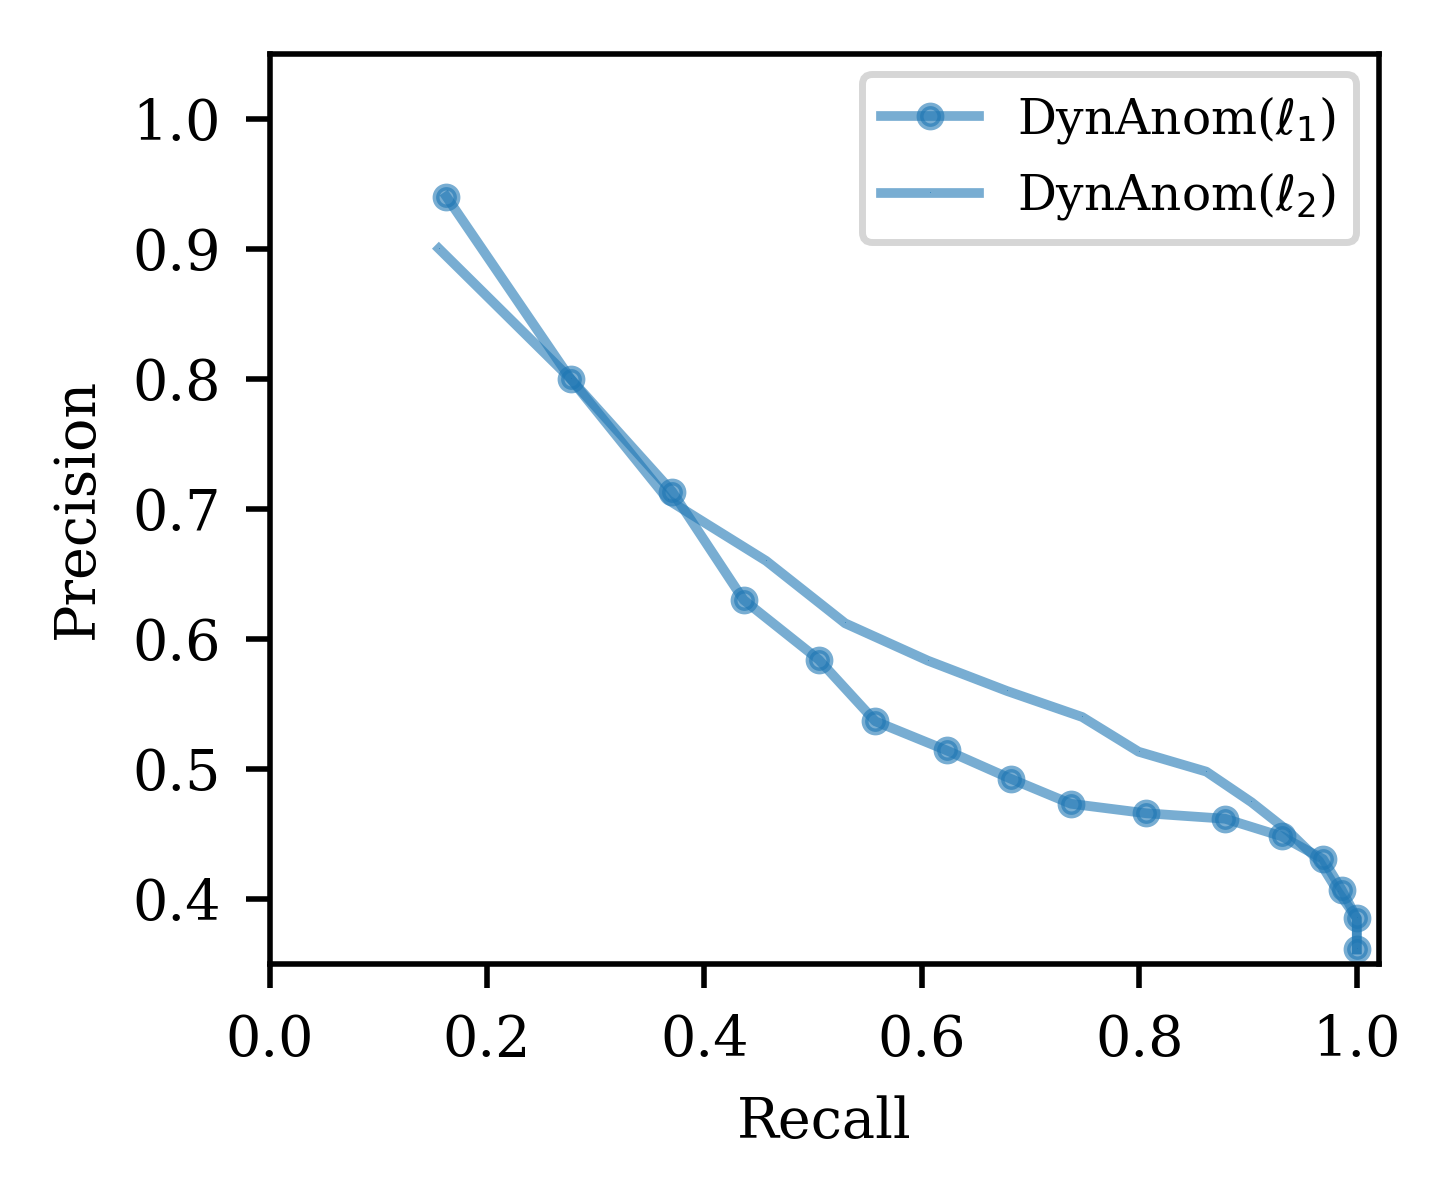

In [3]:
total_configs = []
data_config_str = f'dataset_{dataset_name}-initSS_{initSS}-timeStep_{timeStep}'


color_methods = itertools.cycle(('tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:gray', 'tab:brown', 'tab:purple', 'tab:red', 'tab:olive', 'tab:cyan'))
marker_shape_tuple = ('o',',', '+', '.', '*')
marker_method_variant = itertools.cycle(marker_shape_tuple) 
line_shape_tuple = ("-","--","-.",":")
lines_method_variant = itertools.cycle(line_shape_tuple) 


########################################
#### for Proposed WEIGHTED graph ######
########################################
make_directed_graph = False
make_multi_graph =  True
_color_method = next(color_methods)
marker_method_variant = itertools.cycle(marker_shape_tuple) 
# _marker_method_variant = next(marker_method_variant)


alpha = 0.15
epsilon = 1e-2
track_mode = 'active'
top_index = 200 if 'eucore' in dataset_name else 100
dim = 1024
selective_push_threshold = 1e-4
algo_config_str = f'DynAnomPy-alpha_{alpha:.2e}-epsilon_{epsilon:.2e}-track_mode_{track_mode}-dim-{dim}-top_index_{top_index}-push_threshold-{selective_push_threshold:.2e}-make_directed_graph_{make_directed_graph}-make_multi_graph_{make_multi_graph}'
res_file = os_join(local_out_dir, data_config_str, f'{algo_config_str}_precision_recall_score.csv')
#desc = 'DynAnom-Weighted-100-1e-4'
# desc = 'Weighted'
desc = 'DynAnom'
total_configs.append((data_config_str, algo_config_str, desc, res_file, _color_method, marker_method_variant))


# draw recall-precision curve
topk_index = 100 if 'eucore' in dataset_name else 800 #800
table_index = 20 if 'eucore' in dataset_name else 250 #250
print ('check the top k here')
fig, ax = plt.subplots(1,1, figsize=(3,2.5), dpi =500)
# ax.set_title(f'Precision vs. Recall @Top-{topk_index}| Dataset: {dataset_name}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0,1.02)

ax.set_ylim(0.0 if 'eucore' in dataset_name else 0.35 ,1.05)

alpha = 0.6

print_list = []

for config in total_configs:
    try:
        _dataset_name, _algorithm, _desc, _res_topk_file, line_color, _marker_method_variant = config[0], config[1], config[2], config[3] , config[4],  config[5]
        #print (_algorithm)
        _algorithm = "\n".join(wrap(_algorithm,80))
        pd_topk = pd.read_csv(_res_topk_file)
        
        #print (pd_topk)
        
        if 'anomaly_score' in pd_topk.columns:
            # aggregate by ScoreSource, then plot curve 
            anomaly_scores = pd_topk.loc[:,'anomaly_score'].unique()
            for anomaly_score in anomaly_scores:
                if 'SedanSpot' in anomaly_score :
                    if 'mean' in anomaly_score: #max
                        pass
                    else:
                        continue
                
                if ('DynAnom' in anomaly_score and 'ppe' not in anomaly_score):
                    if 'max' in anomaly_score and 'top10' not in anomaly_score:
                        pass 
                    else:
                        continue 
                    
                if ('DynAnom' in anomaly_score and 'ppe' in anomaly_score):
                    #pass
                    continue 

                if 'tau' in anomaly_score: # only show l1-max curve
                    continue 
                
                _pd_topk = pd_topk[pd_topk['anomaly_score'] == anomaly_score]
                pd_top = _pd_topk[_pd_topk.topk <=topk_index]
                x, y = pd_top.recall.to_list(), pd_top.precision.to_list()
                #_legend =  (anomaly_score+ '-' + _algorithm) if _desc == '' else anomaly_score+ '-' + _desc
                if 'l1' in anomaly_score:
                    dis = '($\ell_1$)'
                elif 'l2' in anomaly_score:
                    dis = '($\ell_2$)'
                else:
                    dis = ''
                _legend =  f'{_desc}{dis}' #(anomaly_score+ '-' + _algorithm) if _desc == '' else anomaly_score+ '-' + _desc

                ax.plot(x,y,label=_legend, marker= next(_marker_method_variant), lw = 1.4 ,ms = '3',color = line_color, alpha = alpha)
                print_row = pd_top[pd_top['topk']==table_index]
                print_list.append(print_row)
        else:
            pd_top = pd_topk[pd_topk.topk <=topk_index]
            x, y = pd_top.recall.to_list(), pd_top.precision.to_list()
            _legend =  _algorithm if _desc == '' else _desc
            ax.plot(x,y,label=_legend, marker= next(_marker_method_variant),color = line_color, lw = 1.4 ,ms = '3' , alpha = alpha)
            print_row = pd_top[pd_top['topk']==table_index]
            print_list.append(print_row)

    except Exception as e:
        print (e)

fig.legend(loc='upper right', bbox_to_anchor=(0.92, 0.92), fontsize = 7)
fig.tight_layout()
# fig.savefig(f'/figs/fig-res-{_dataset_name}-topk-recall-precision.pdf',format = "pdf", bbox_inches ='tight', dpi = 500)

pd_top250_res = pd.concat(print_list, axis=0).reset_index(drop=True)
print (pd_top250_res[['anomaly_score', 'precision']].to_latex(index=False, float_format = '%.4f'))


### Node-level experiments

### ```dataset_name``` can be: ``` [darpa, eucore_inject_1, eucore_inject_3]```

In [4]:
dataset_name = 'darpa' # darpa  eucore_inject_1, eucore_inject_3.
if dataset_name == 'darpa':
# dataset_name = 'darpa' #enron darpa
    timeStep = 60 # seconds per day 
    initSS = 256 # 256 for enron
if dataset_name == 'enron':
    timeStep = 60*60*24 # seconds per day 
    initSS = 256 # 256 for enron
elif dataset_name == 'eucore_inject_1' or  dataset_name == 'eucore_inject_2' or  dataset_name == 'eucore_inject_3':
    timeStep = 3600*24*7 #total 114, effective 78
    initSS = 25 # ~first 1/4 snapshots

data_path = path = os_join(project_root,'toy-data', f'{dataset_name}.txt') #enron.txt  darpa.txt
degree_t, dangling_nums = test_graph_stream(path, dataset_name, timeStep = timeStep, initSS = initSS)
#print (degree_t, dangling_nums)


total_configs = []
data_config_str = f'dataset_{dataset_name}-initSS_{initSS}-timeStep_{timeStep}'


color_methods = itertools.cycle(('tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:gray', 'tab:brown', 'tab:purple', 'tab:red', 'tab:olive', 'tab:cyan'))
marker_shape_tuple = ('o',',', '+', '.', '*')
marker_method_variant = itertools.cycle(marker_shape_tuple) 
line_shape_tuple = ("-","--","-.",":")
lines_method_variant = itertools.cycle(line_shape_tuple) 


make_directed_graph = False
make_multi_graph =  True
_color_method = next(color_methods)
marker_method_variant = itertools.cycle(marker_shape_tuple) 

alpha = 0.15
epsilon = 1e-2
track_mode = 'definitive'
top_index = 200
dim = 1024
selective_push_threshold = 1e-4
algo_config_str = f'DynAnomPy-alpha_{alpha:.2e}-epsilon_{epsilon:.2e}-track_mode_{track_mode}-dim-{dim}-top_index_{top_index}-push_threshold-{selective_push_threshold:.2e}-make_directed_graph_{make_directed_graph}-make_multi_graph_{make_multi_graph}'
res_file = os_join(local_out_dir, data_config_str, f'{algo_config_str}_snapshot_anomaly_score_node_wise.csv')
desc = 'Weighted'
total_configs.append((data_config_str, algo_config_str, desc, res_file, _color_method, marker_method_variant))


for config in total_configs:
    try:
        _dataset_name, _algorithm, _desc, _res_topk_file, line_color, _marker_method_variant = config[0], config[1], config[2], config[3] , config[4],  config[5]
        #print (_algorithm)
        _algorithm = "\n".join(wrap(_algorithm,80))
        pd_topk = pd.read_csv(_res_topk_file, index_col=False)
        print (_algorithm)
        print (pd_topk.groupby('anom_type').mean())
        
    except Exception as e:
        print (e)



4554344it [00:11, 397204.67it/s]


min time: 0,  max time: 87725
#nodes:25525 , #edges:4554344, timeNum:87726, total snapshots: 1463, init snapshots: 256, effective snapshots :966


  0%|          | 0/966 [00:00<?, ?it/s]

DynAnomPy-alpha_1.50e-01-epsilon_1.00e-02-track_mode_definitive-
dim-1024-top_index_200-push_threshold-1.00e-04-make_directed_graph_False-
make_multi_graph_True
                      node_id  num_anom  precision    recall        f1
anom_type                                                             
l1               13892.193333  4.593333   0.542505  0.542505  0.542505
l1-filtered      13892.193333  4.593333   0.988261  0.988261  0.988261
l2               13892.193333  4.593333   0.339559  0.339559  0.339559
l2-filtered      13892.193333  4.593333   0.988621  0.988621  0.988621
random           13892.193333  4.593333   0.007523  0.007523  0.007523
random-filtered  13892.193333  4.593333   0.987464  0.987464  0.987464


## Case Study

In [5]:
# Enron Graph
# graph level 

def test_graph_stream(path, dataset_name, timeStep = 60, initSS = 256):
    ################################################################
    ####    Graph snapshots construcution
    ################################################################
    # Some edge stream may only have 10 edges,  but results in 100 snapshots.
    # In this case, a great amount of snapshots are equal since no edge event happens between many of them.
    
    #timeStep = 60 #time interval of one snapshot, e.g.: 60 mins; or 60 sec
    n, m, timeNum, nodes, edges, snapshots, anomalous_nodes_desc, initial_time, sort_time = graph_data_utils.read_data_for_exp3(path, timeStep)
    attackLimit = 50 # threshold for attack snapshot anomaly
    Inject_param = False 
    #initSS = 256
    injectNum = 50
    injectSize = 70
    numSS = timeNum//timeStep + 1
    testNum = numSS - initSS
    #attack = np.zeros(testNum+1) # the groud-truth of each snapshot

    print (f'#nodes:{n} , #edges:{m}, timeNum:{timeNum}, total snapshots: {numSS}, init snapshots: {initSS}, effective snapshots :{len(snapshots)}')
    print (initial_time)
    # choose which snapshots should be injected with random edges as anomaly 
    # it will add new effective snapshots (step).

    # different data structure of graph
    A = dict()
    dir_g = nx.DiGraph()
    sp_lil_M = lil_matrix((n, n))
    sp_lil_M_weight = lil_matrix((n, n))
    eg = 0
    injected = 0
    current_m = 0
    
    ## graph information:
    degree_t = np.zeros(numSS+1)
    dangling_nums = np.zeros(numSS+1)
    
    ################################################################
    ####    Iterate snapshot and calculate anomaly scores 
    ################################################################
    for ss in tqdm(range(len(snapshots))):        
        # count the total number of attack edges in this snapshot, 
        # if > attackLimit, then this snapshot is anomalous
        attackNum = 0
        
        # Incrementally update graph
        while edges[eg][2] < snapshots[ss]*timeStep:
            # If this edge happens before the time border, inject edges/update graph. 
            graph_data_utils.inject(A, edges[eg][0], edges[eg][1], 1, dir_g, sp_lil_M, sp_lil_M_weight)
            current_m += 1 # current_m records current all injected edges, including artifically augmented anomalous edges
            
            # this edge is anomalous by its label.
            if edges[eg][3] == 1:
                attackNum += 1 

            eg+=1 # eg only records the number of edge in the original graph, excluding augmented edges
            # reach to the end, break
            if eg == len(edges):
                break
            
        snapshot_num = snapshots[ss]
        degree_t[snapshot_num] = current_m
        dangling_nums[snapshot_num]= np.count_nonzero(np.array(sp_lil_M.sum(1).squeeze())==0) # count no outdegree

    return degree_t, dangling_nums, sort_time


project_root = '../'
dataset_name = 'enron' #enron darpa  eucore_inject_1, eucore_inject_3.
# assert dataset_name in ['darpa', 'enron','eucore_inject_1', 'eucore_inject_2']
if dataset_name == 'darpa':
# dataset_name = 'darpa' #enron darpa
    timeStep = 60 # seconds per day 
    initSS = 256 # 256 for enron
if dataset_name == 'enron':
    timeStep = 60*60*24 # seconds per day 
    initSS = 256 # 256 for enron
elif dataset_name == 'eucore_inject_1' or  dataset_name == 'eucore_inject_2' or  dataset_name == 'eucore_inject_3':
    timeStep = 3600*24*7 #total 114, effective 78
    initSS = 25 # ~first 1/4 snapshots

data_path = path = os_join(project_root,'toy-data', f'{dataset_name}.txt') #enron.txt  darpa.txt
degree_t, dangling_nums, sort_time= test_graph_stream(path, dataset_name, timeStep = timeStep, initSS = initSS)
print (degree_t, dangling_nums)
data_config_str = f'dataset_{dataset_name}-initSS_{initSS}-timeStep_{timeStep}'


total_configs = []

make_directed_graph = False
make_multi_graph =  True
alpha = 0.15
epsilon = 1e-2
track_mode = 'active'
top_index = 100
dim = 512
selective_push_threshold = 1e-4
algo_config_str = f'DynAnomPy-alpha_{alpha:.2e}-epsilon_{epsilon:.2e}-track_mode_{track_mode}-dim-{dim}-top_index_{top_index}-push_threshold-{selective_push_threshold:.2e}-make_directed_graph_{make_directed_graph}-make_multi_graph_{make_multi_graph}'
res_file = os_join(local_out_dir, data_config_str, f'{algo_config_str}_snapshot_anomaly_score.csv')
desc = ''
total_configs.append((data_config_str, algo_config_str, desc, res_file))

algorithm = 'AnomRankPy' #AnomRankPy, AnomRankC
alpha = 0.5
epsilon = 1e-2
algo_config_str = f'AnomRankPy-alpha_{alpha:.2e}-epsilon_{epsilon:.2e}'
desc = ''
res_file = os_join(local_out_dir, data_config_str, f'{algo_config_str}_snapshot_anomaly_score.csv')
total_configs.append((data_config_str, algo_config_str, desc, res_file))


algo_config_str = f'SedanSpotC'
res_file = os_join(local_out_dir, data_config_str, f'{algo_config_str}_snapshot_anomaly_score.csv')
desc = ''
total_configs.append((data_config_str, algo_config_str, desc, res_file))



min time: 926389620,  max time: 1024674019
#nodes:151 , #edges:50572, timeNum:98284400, total snapshots: 1138, init snapshots: 256, effective snapshots :902
926389620


  0%|          | 0/902 [00:00<?, ?it/s]

[0.0000e+00 4.0000e+00 5.0000e+00 ... 5.0566e+04 0.0000e+00 5.0572e+04] [  0. 149. 148. ...   0.   0.   0.]


In [6]:
from dateutil.parser import parse
time_event = []
with open('../toy-data/enron-events.txt','r') as f:
    for _line in f:
        line = _line.strip()
        if line == '':
            continue
        _date, _event = line.split('--', 1)
        _date = _date.strip()
        _event = _event.strip()
        _date = parse(_date)
        time_event.append([_date.timestamp(), _event])
time_event = time_event[5:65]
print (time_event[:3])

print_events_ind =  set([3,6,8,13,26,37,39,42,48,58])
print_events = []
for ind, (time, event) in enumerate(time_event):
    if ind in print_events_ind:
        print_events.append((time, event))
print (print_events)


[[958978800.0, "The California ISO (Independent System Operator), the organization in charge of California's electricity supply and demand, declares a Stage One Emergency, warning of low power reserves."], [960793200.0, 'Skilling makes joke at Las Vegas conference, comparing California to the Titanic.'], [962434800.0, 'Enron announces that its Broadband unit (EBS) has joined forces with Blockbuster to supply video-on-demand.']]
[(967014000.0, 'Stock hits all-time high of $90.56. Market valuation of $70 billion. FERC (the Federal Energy Regulatory Commission) orders an investigation into strategies designed to drive electricity prices up in California.'), (973065600.0, 'FERC investigation exonerates Enron for any wrongdoing in California.'), (976694400.0, 'Enron announces that president and chief operating officer Jeffrey Skilling will take over as chief executive in February. Kenneth Lay will remain as chairman.'), (980409600.0, 'Analyst Conference in Houston, Texas. Skilling bullish o

Index(['DynAnomScore(l1-sum)', 'DynAnomScore(l1-mean)', 'DynAnomScore(l1-median)', 'DynAnomScore(l1-max)', 'DynAnomScore(l1-min)', 'DynAnomScore(l1-max-top10)', 'DynAnomScore(l2-sum)', 'DynAnomScore(l2-mean)', 'DynAnomScore(l2-median)', 'DynAnomScore(l2-max)', 'DynAnomScore(l2-min)', 'DynAnomScore(l2-max-top10)', 'DynAnomScore(l1-sum-ppe)', 'DynAnomScore(l1-mean-ppe)', 'DynAnomScore(l1-median-ppe)', 'DynAnomScore(l1-max-ppe)', 'DynAnomScore(l1-min-ppe)', 'DynAnomScore(l1-max-top10-ppe)', 'DynAnomScore(l2-sum-ppe)', 'DynAnomScore(l2-mean-ppe)', 'DynAnomScore(l2-median-ppe)', 'DynAnomScore(l2-max-ppe)', 'DynAnomScore(l2-min-ppe)', 'DynAnomScore(l2-max-top10-ppe)', 'Label'], dtype='object')
(877,) (877,)
\begin{tabular}{rll}
\toprule
 index &       date &                                                                                                                                                                                                                         event \\
\midrule
   

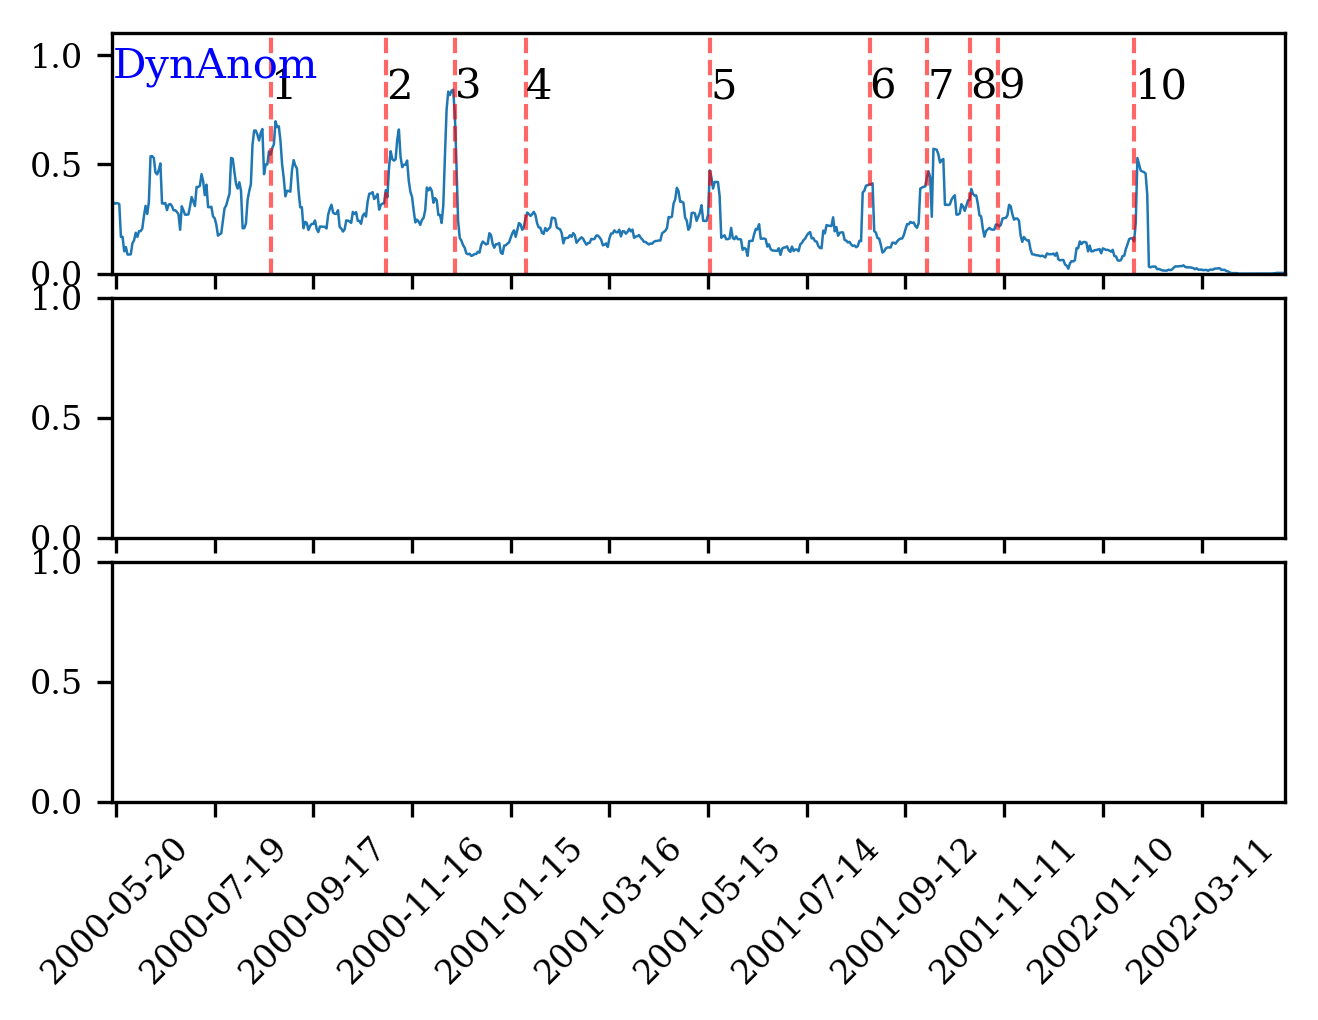

In [7]:

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#max_rolling1 moving_average
# def moving_average(a, window, axis =1):
#         shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
#         strides = a.strides + (a.strides[-1],)
#         rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
#         return np.max(rolling,axis=axis)


init_time = 926389620 # ~2000-05-20
test_time = init_time + timeStep*(initSS)
fig, axs = plt.subplots(3,1,figsize=(4.5,3.5), dpi=300, sharex = True)
axs = axs.flatten()
plot_raw_event = False
plot_vline_color='r'
plot_vline_alpha = 0.6
plot_vline_style = '--'
plot_line_width = 0.6


smooth_window = 7
ax = axs[0]
_dataset_name, _algorithm, _desc, _res_file = total_configs[0]
_algorithm_split = "\n".join(wrap(_algorithm,60))
pd_res = pd.read_csv(_res_file)
print (pd_res.columns)

res = pd_res.loc[:, 'DynAnomScore(l1-mean)'].to_numpy()
res_avg =  moving_average(res, smooth_window)
res_avg = res_avg/res_avg.max()
xticks_lbs = [ datetime.datetime.fromtimestamp(test_time+i*timeStep).strftime('%Y-%m-%d') for i in range(res.shape[0])][:-smooth_window+1]
x_seconds = np.array([ test_time+i*timeStep for i in range(res.shape[0])])[:-smooth_window+1]
print (x_seconds.shape, res_avg.shape)
ax.plot(x_seconds, res_avg, lw = plot_line_width)

ax.set_xticks(x_seconds[::60])
ax.set_xticklabels(xticks_lbs[::60])
ax.tick_params(axis='x', labelrotation = 45)
# plot the events

if plot_raw_event:
    for ind, (time, event) in enumerate(time_event):
        ax.axvline(x=time, lw = 0.5, color ='r')
        ax.text(x=time, y=ind/80, s = f'{ind}')
    
for ind, (time, event) in enumerate(print_events):
    ax.axvline(x=time, lw = 1.0, color =plot_vline_color, alpha=plot_vline_alpha, ls = plot_vline_style)
    ax.text(x=time, y=0.8, s = f'{ind+1}')
ax.text(x=958681780, y=0.9, s = f'DynAnom', color = 'b')
ax.set_xlim(958681780,1020284969)
ax.set_ylim(0.0,1.1)

ax = axs[2]
ax.tick_params(axis='x', labelrotation = 45)


# ax = axs[1]
# _dataset_name, _algorithm, _desc, _res_file = total_configs[1]
# _algorithm_split = "\n".join(wrap(_algorithm,60))
# pd_res = pd.read_csv(_res_file)
# print (pd_res.columns)
# res = pd_res.loc[:, ' AnomRankW'].to_numpy()
# res_avg =  moving_average(res, smooth_window)
# res_avg = res_avg/res_avg.max()
# xticks_lbs = [ datetime.datetime.fromtimestamp(test_time+i*timeStep).strftime('%Y-%m-%d') for i in range(res.shape[0])][:-smooth_window+1]
# x_seconds = np.array([ test_time+i*timeStep for i in range(res.shape[0])])[:-smooth_window+1]
# print (x_seconds.shape, res_avg.shape)
# ax.plot(x_seconds, res_avg, lw = plot_line_width)

# ax.set_xticks(x_seconds[::60])
# ax.set_xticklabels(xticks_lbs[::60])
# ax.tick_params(axis='x', labelrotation = 45)
# # plot the events

# if plot_raw_event:
#     for ind, (time, event) in enumerate(time_event):
#         ax.axvline(x=time, lw = 0.5, color ='r')
#         ax.text(x=time, y=ind/80, s = f'{ind}')
# for ind, (time, event) in enumerate(print_events):
#     ax.axvline(x=time, lw = 1.0, color =plot_vline_color, alpha=plot_vline_alpha, ls = plot_vline_style)
#     ax.text(x=time, y=0.8, s = f'{ind+1}')
# ax.text(x=958681780, y=0.9, s = f'AnomRankW', color = 'b')
# ax.set_xlim(958681780,1020284969)
# ax.set_ylim(0.0,1.1)


# ax = axs[2]
# _dataset_name, _algorithm, _desc, _res_file = total_configs[2]
# _algorithm_split = "\n".join(wrap(_algorithm,60))
# pd_res = pd.read_csv(_res_file)
# print (pd_res.columns)
# res = pd_res.loc[:, ' SedanMax'].to_numpy()
# res_avg =  moving_average(res, smooth_window)
# res_avg = res_avg/res_avg.max()
# xticks_lbs = [ datetime.datetime.fromtimestamp(test_time+i*timeStep).strftime('%Y-%m-%d') for i in range(res.shape[0])][:-smooth_window+1]
# x_seconds = np.array([ test_time+i*timeStep for i in range(res.shape[0])])[:-smooth_window+1]
# print (x_seconds.shape, res_avg.shape)
# ax.plot(x_seconds, res_avg, lw = plot_line_width)

# ax.set_xticks(x_seconds[::60])
# ax.set_xticklabels(xticks_lbs[::60])
# ax.tick_params(axis='x', labelrotation = 45)
# # plot the events
# if plot_raw_event:
#     for ind, (time, event) in enumerate(time_event):
#         ax.axvline(x=time, lw = 0.5, color ='r')
#         ax.text(x=time, y=ind/80, s = f'{ind}')    
# for ind, (time, event) in enumerate(print_events):
#     ax.axvline(x=time, lw = 1.0, color =plot_vline_color, alpha=plot_vline_alpha, ls = plot_vline_style)
#     ax.text(x=time, y=0.8, s = f'{ind+1}')
# ax.text(x=958681780, y=0.9, s = f'SedanSpot', color = 'b')
# ax.set_xlim(958681780,1020284969)
# ax.set_ylim(0.0,1.1)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)

event_dict_list = []
for i, (t,e) in enumerate(print_events):
    #print (i+1, datetime.datetime.fromtimestamp(t).strftime('%Y/%m/%d'),e)
    event_dict_list.append({'index': i+1, 'date':datetime.datetime.fromtimestamp(t).strftime('%Y/%m/%d'), 'event':e})
df_event = pd.DataFrame.from_records(event_dict_list)

print (df_event.to_latex(index = False))
#print (pd_event_desc)

# Exp3-1: EventKG case study -select

In [8]:
node_desc_path = '../toy-data/PEGraph-nodes.txt'

data_holder = []
with open(node_desc_path,'r') as f:
    for line in f:
        try:
            #[9, "entity_402568", ["Joyce D. Miller"]]
            node_id, node_raw_id, node_desc_list = json.loads(line)
            node_desc_str = ' | '.join(node_desc_list).lower()
            #print (node_id, node_raw_id, node_desc_str)
            node_type = node_raw_id.split('_')[0]
            data_holder.append([node_id, node_raw_id, node_type, node_desc_str])
        except:
            print (line)
            break
df_node = pd.DataFrame(data_holder, columns = ['node_id', 'node_uuid', 'node_type','desc' ])
df_node_entity = df_node[df_node['node_type'] == 'entity']

#2106059	2106059	entity_3916214	entity	melania trump | мелания тръмп | трамп, мелания
#2277320	2277320	entity_9779081	entity	arnold schwarzenegger | арнольд шварценеггер | арнолд шварценегер | шварценеггер, арнольд
#1382419	1382419	entity_7986781	entity	robert carlyle byrd | робърт бърд | robert byrd | роберт бёрд | бёрд, роберт
#989898	    989898  entity_8231965	entity	фред гранди | fred grandy
#1003585	1003585	entity_8623844	entity	франкен, эл | al franken
#1306232	1306232	entity_1338424	entity	jerry springer | спрингер, джерри
#2076914	2076914	entity_10098191	entity	мелисса гилберт | мелиса гилбърт | melissa gilbert | гилберт, мелисса
#953535	    953535	entity_2718902	entity	байден, джо | джо байдън | джо байден | joe biden

In [9]:
df_node_entity[df_node_entity['desc'].astype(str).str.contains("joe * biden".lower())]

,node_id,node_uuid,node_type,desc
953535,953535,entity_2718902,entity,"байден, джо | джо байдън | джо байден | joe biden"


In [10]:
target_node_ids = [
    [2106059, "entity_3916214","melania trump"],
    [2277320, "entity_9779081","arnold schwarzenegger"],
    [1382419, "entity_7986781","robert carlyle byrd"],
    [989898, "entity_8231965","fred grandy"],
    [1003585, "entity_8623844","al franken"],
    [1306232, "entity_1338424","jerry springer"],
    [2076914, "entity_10098191","melissa gilbert"],
    [953535, "entity_2718902","joe biden"],
]

"""    
project_root = '../'
dataset_name = 'PEGraph-1900-2022'
track_file_path = os_join(project_root,'toy-data', f'{dataset_name}-tracking.json') 
with open(track_file_path,'w') as wf:
    for _ in target_node_ids:
        wf.write(json.dumps(_))
        wf.write('\n')
"""

"    \nproject_root = '../'\ndataset_name = 'PEGraph-1900-2022'\ntrack_file_path = os_join(project_root,'toy-data', f'{dataset_name}-tracking.json') \nwith open(track_file_path,'w') as wf:\n    for _ in target_node_ids:\n        wf.write(json.dumps(_))\n        wf.write('\n')\n"

In [11]:
from sklearn.utils import murmurhash3_32 as murmurhash
def get_hash_LUT(n,dim = 512):
    node_id_2_dim_id = np.zeros(n,dtype=np.int32)
    node_id_2_sign = np.zeros(n,dtype=np.int8)
    for _ in tqdm (range(n)):
        dim_id = murmurhash(_, seed = 0,positive=True)%dim
        sign = murmurhash(_, seed = 0,positive=True)%2
        node_id_2_dim_id[_] = dim_id
        node_id_2_sign[_] = 1 if sign == 1 else -1
    return node_id_2_dim_id, node_id_2_sign
node_id_2_dim_id, node_id_2_sign = get_hash_LUT(609930,dim = 1024)


  0%|          | 0/609930 [00:00<?, ?it/s]

In [12]:

target_node_ids = [
    [2106059, "entity_3916214","melania trump"],
    [2277320, "entity_9779081","arnold schwarzenegger"],
    [1382419, "entity_7986781","robert carlyle byrd"],
    [989898, "entity_8231965","fred grandy"],
    [1003585, "entity_8623844","al franken"],
    [1306232, "entity_1338424","jerry springer"],
    [2076914, "entity_10098191","melissa gilbert"],
    [953535, "entity_2718902","joe biden"],
]

# p_cutoff_threshold =  1/609930
p_cutoff_threshold =  5e-5

def l_p_err_nnz_row(a,  b, top_k = 100, l=1):
    # get l1-error of shared_nodes rows of sparse matrices.
    a = np.array(a.todense())[0]
    b = np.array(b.todense())[0]
    
    a[a<p_cutoff_threshold] = 0.0
    b[b<p_cutoff_threshold] = 0.0
    
    top_ind_a = a.nonzero()[0]
    top_ind_b = b.nonzero()[0]
    uni_ind = np.union1d(top_ind_a, top_ind_b)
    a = a[uni_ind]
    b = b[uni_ind]
    
    a = a / np.sum(a) #np.sqrt(np.sum(a**2))
    b = b / np.sum(b) #np.sqrt(np.sum(b**2))

    _dis = np.linalg.norm(a-b, ord =l)
    return _dis


def cal_kendalltau(a,b, top_k = 100):
    a = np.array(a.todense())[0]
    b = np.array(b.todense())[0]
    
    a[a<p_cutoff_threshold] = 0.0
    b[b<p_cutoff_threshold] = 0.0

    top_ind_a = a.nonzero()[0]
    top_ind_b = b.nonzero()[0]
    uni_ind = np.union1d(top_ind_a, top_ind_b)
    a = a[uni_ind]
    b = b[uni_ind]
    
    a = a / np.sum(a) #np.sqrt(np.sum(a**2))
    b = b / np.sum(b) #np.sqrt(np.sum(b**2))

    
    kendalltau = stats.kendalltau(a, b)
    arr_inv_tau = (1-kendalltau[0])/2
    return arr_inv_tau


def cal_kendalltau_v2(a,b, top_k = 100):
    a = np.array(a.todense())[0]
    b = np.array(b.todense())[0]
    
    a[a<p_cutoff_threshold] = 0.0
    b[b<p_cutoff_threshold] = 0.0

    top_ind_a = a.nonzero()[0]
    top_ind_b = b.nonzero()[0]
    uni_ind = np.union1d(top_ind_a, top_ind_b)
    a = a[uni_ind]
    b = b[uni_ind]
    
    a = a / np.sum(a) #np.sqrt(np.sum(a**2))
    b = b / np.sum(b) #np.sqrt(np.sum(b**2))

    vec_a_support_rank = a.shape[0] - (rankdata(a, method='ordinal')).astype(int)
    vec_b_support_rank = b.shape[0] - (rankdata(b, method='ordinal')).astype(int)

    kendalltau = stats.kendalltau(vec_a_support_rank, vec_b_support_rank)
    arr_inv_tau = (1-kendalltau[0])/2
    return arr_inv_tau




def get_hash_embed(node_id_2_dim_id, node_id_2_sign, m, dim = 1024):
    emb_mat = np.zeros((dim), dtype=np.float32)
    for j in range(m.shape[0]):
        val = m[j]
        if val <= 1e-6:
            continue
        emb_mat[node_id_2_dim_id[j]] =+ node_id_2_sign[j]* np.max( np.array([np.float32(0.0), np.float32(np.log(val*609930))]) )
    emb_mat = emb_mat.reshape(-1)
    return emb_mat



def l_p_err_nnz_row_emb(a, b, l=1):
    # get l1-error of shared_nodes rows of sparse matrices.
    a = np.array(a.todense())[0]
    b = np.array(b.todense())[0]
    

    a = get_hash_embed(node_id_2_dim_id, node_id_2_sign, a)
    b = get_hash_embed(node_id_2_dim_id, node_id_2_sign, b)
    a = a / np.sum(a) #np.sqrt(np.sum(a**2))
    b = b / np.sum(b) #np.sqrt(np.sum(b**2))

    _dis = np.linalg.norm(a-b, ord =l)
    return _dis



In [13]:
target_node_ids

[[2106059, 'entity_3916214', 'melania trump'],
 [2277320, 'entity_9779081', 'arnold schwarzenegger'],
 [1382419, 'entity_7986781', 'robert carlyle byrd'],
 [989898, 'entity_8231965', 'fred grandy'],
 [1003585, 'entity_8623844', 'al franken'],
 [1306232, 'entity_1338424', 'jerry springer'],
 [2076914, 'entity_10098191', 'melissa gilbert'],
 [953535, 'entity_2718902', 'joe biden']]

In [14]:
pd_target_nodes = pd.DataFrame(target_node_ids, columns = ['external_id', 'external_uuid', 'desc'])

target_status = dict()
prev_ppv_dict = dict()

top_k = 500
for entry in pd_target_nodes.to_records():
    print (entry[1], entry[3])
    target_status[entry[1]] = dict()
    target_status[entry[1]]['desc'] = entry[3]
    target_status[entry[1]]['history'] = []
    prev_ppv_dict[entry[1]] = None
    
track_files_path = '../out/dataset_PEGraph-1980-2022-degcut-5-initSS_1-timeStep_31536000/DynAnomPy-alpha_7.00e-01-epsilon_1.00e-02-track_mode_definitive-dim-512-top_index_9999-push_threshold-0.00e+00-make_directed_graph_False-make_multi_graph_True'


for snapshot in tqdm(range(20,44)):
    with open(os_join(track_files_path, f'{snapshot:05}.pkl'), 'rb') as f:
        data_dict = pickle.load(f)
        # print (data_dict.keys())
        # print (data_dict['sp_ppv'])
        # print (data_dict['tracking_nodes_internal_ids'])
        # print (data_dict['tracking_nodes_external_ids'])
        # print (data_dict['node_degree'])
        # print (data_dict['delta_node_degree'])
        
        zip_data = zip( data_dict['tracking_nodes_internal_ids'], \
                        data_dict['tracking_nodes_external_ids'], \
                        data_dict['node_degree'], data_dict['delta_node_degree'] \
                        )
        ppv_mat = data_dict['sp_ppv']
        #print (ppv_mat.shape)
                
        for internal_id, external_id, d, delta_d in zip_data: #track this person...
            curt_ppv = ppv_mat[internal_id,:]
            #num_supps = curt_ppv.count_nonzero()
            num_supps =  np.count_nonzero(np.array(curt_ppv.todense())[0]>=p_cutoff_threshold) 
            prev_ppv = prev_ppv_dict.get(external_id, None)
            
            if prev_ppv is None:
                l1_dis = 0.0
                l2_dis = 0.0
                emb_l1_dis = 0.0
                emb_l2_dis = 0.0
                kendalltau = 0.0
                kendalltau_v2 = 0.0
                prev_ppv_dict[external_id] = curt_ppv
            else:
                # get the top index 
                l1_dis = l_p_err_nnz_row(curt_ppv, prev_ppv, top_k = top_k, l=1)
                l2_dis = l_p_err_nnz_row(curt_ppv, prev_ppv, top_k = top_k, l=2)
                # emb_l1_dis = l_p_err_nnz_row_emb(curt_ppv, prev_ppv, l=1)
                # emb_l2_dis = l_p_err_nnz_row_emb(curt_ppv, prev_ppv, l=2)
                emb_l1_dis = 0.0
                emb_l2_dis = 0.0
                kendalltau = cal_kendalltau(curt_ppv, prev_ppv, top_k = top_k)
                kendalltau_v2 = cal_kendalltau_v2(curt_ppv, prev_ppv, top_k = top_k)
                # print ('curt:', id(curt_ppv))
                # print ('prev:', id(prev_ppv))
                prev_ppv_dict[external_id] = curt_ppv
                target_status[external_id]['history'].append((snapshot+1979, num_supps, d, delta_d, l1_dis, l2_dis, kendalltau, kendalltau_v2, emb_l1_dis, emb_l2_dis))
        

2106059 melania trump
2277320 arnold schwarzenegger
1382419 robert carlyle byrd
989898 fred grandy
1003585 al franken
1306232 jerry springer
2076914 melissa gilbert
953535 joe biden


  0%|          | 0/24 [00:00<?, ?it/s]

In [15]:
df_history_person = dict()
for external_id in target_status.keys():
    node_desc = target_status[external_id]['desc']
    df_history = pd.DataFrame(target_status[external_id]['history'], columns = ['snapshot', 'supports','degree', 'delta-degree', 'l1-dis','l2-dis', 'tau','tau-v2', 'emb-l1-dis','emb-l2-dis'])
    df_history_person[node_desc] = df_history

df_history_person.keys()

dict_keys(['melania trump', 'arnold schwarzenegger', 'robert carlyle byrd', 'fred grandy', 'al franken', 'jerry springer', 'melissa gilbert', 'joe biden'])

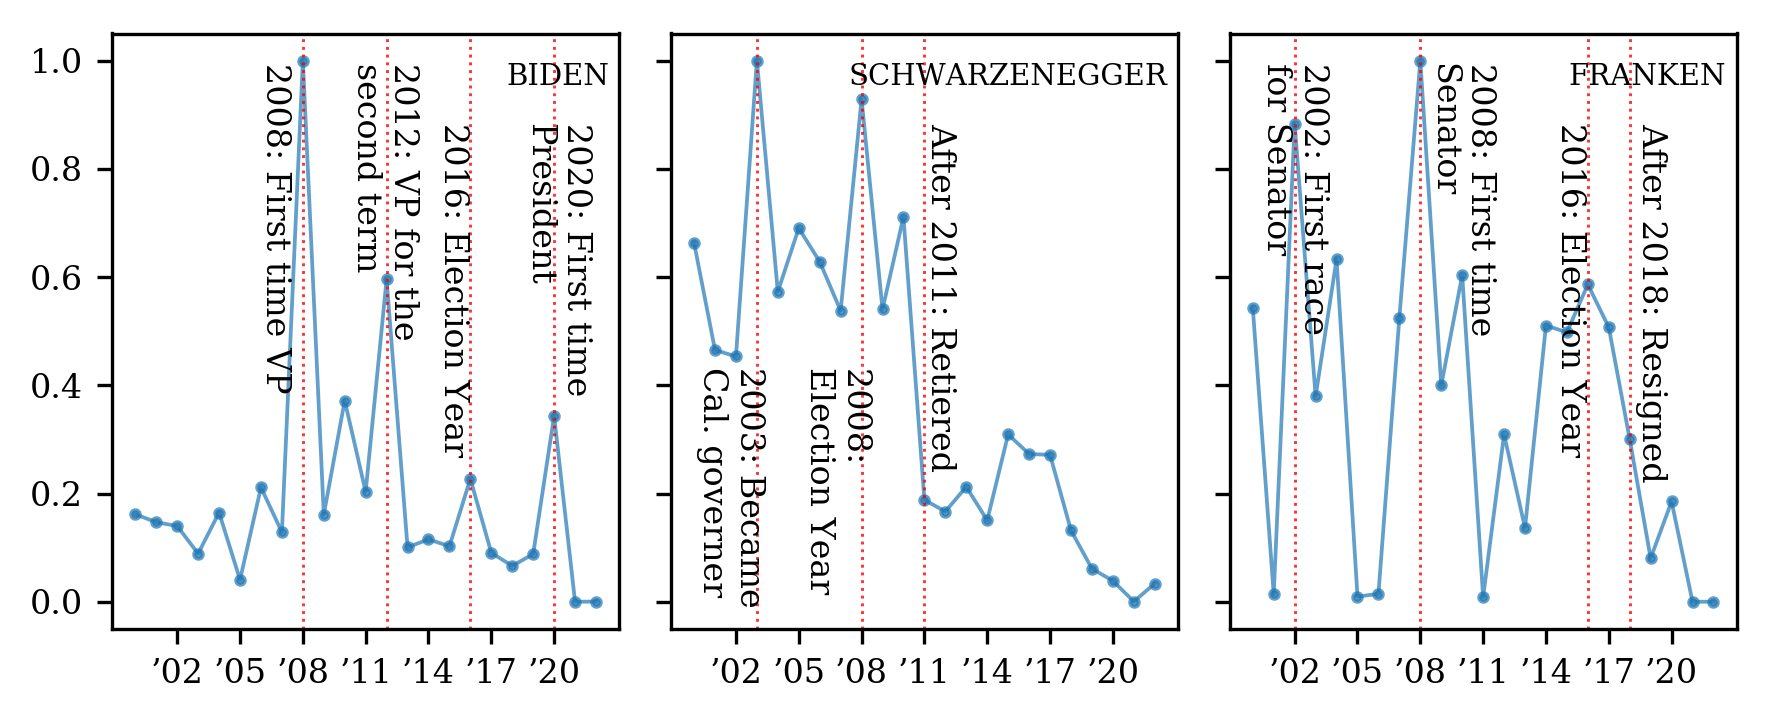

In [16]:
## write individual 
#'melania trump', 'arnold schwarzenegger', 'robert carlyle byrd', 'fred grandy', 'al franken', 'jerry springer', 'melissa gilbert', 'joe biden'
names = [ 'joe biden', 'arnold schwarzenegger', 'al franken' ]
fig, axs = plt.subplots(1,len(names), figsize =(6, 2.5), dpi =300, sharey=True)
axs = axs.flatten()

# ax_id = 0
# df_history_person[name].plot(x = 'snapshot', y = 'delta-degree', marker='o', ax = axs[ax_id]) #l2-dis

def _extract_year(year):
    return f'’{str(year)[2:4]}'

plot_vline_color = 'r'
plot_vline_alpha = 0.8
plot_vline_style = ':'
plot_vline_width = 0.7
for ax_id, name in enumerate(names):
    ax =  axs[ax_id]
    if df_history_person[name].shape[0] == 0:
        continue 
    # df_history_person[name].plot(x = 'snapshot', y = 'l1-dis', marker='o', ax = ax) #l2-dis
    x = df_history_person[name]['snapshot'].to_numpy()
    y = df_history_person[name]['l1-dis'].to_numpy()
    y = y/max(y)
    ax.plot(x,y,label = r'$\ell_1$ distance', lw = 0.9, marker = 'o', alpha = 0.7)
    #ax.get_legend().remove()
    x = df_history_person[name]['snapshot'].to_numpy()
    y = df_history_person[name]['delta-degree'].to_numpy()
    y = y/max(y)
    # ax.plot(x,y,label = 'Degree change', ls = '--', lw = 0.7, marker = 'o')
    display_name = name.split(' ')[-1]
    ax.text(0.98, 0.95, f'{display_name.upper()}', horizontalalignment='right',verticalalignment='top',transform = ax.transAxes, fontsize = 7)
    ax.set_xticks(x[2::3])
    ax.set_xticklabels( [_extract_year(_) for _ in x[2::3]], rotation=-0, ha = 'center')

    if name == 'arnold schwarzenegger':
            time_desc = [
                (2003 ,0.05, 0.44,'left','2003: Became \nCal. governer'),
                (2008, 0.26, 0.44,'left','2008: \nElection Year '),
                # (2010, 0.40, 0.53,'left','2010: Mid-term election'),
                (2011, 0.50, 0.85,'left','After 2011: Retiered'),
            ]

            for time, x, y, ha, text in time_desc:
                ax.text(x, y, text, horizontalalignment=ha,verticalalignment='top',transform = ax.transAxes, size= 8, rotation = -90)
                ax.axvline(x=time, lw = plot_vline_width, color =plot_vline_color, alpha=plot_vline_alpha, ls = plot_vline_style)

    if name == 'joe biden':
            time_desc = [
                (2008, 0.29, 0.95,'left','2008: First time VP '),
                (2012, 0.47, 0.95,'left','2012: VP for the \nsecond term'),
                (2016, 0.64, 0.85,'left','2016: Election Year'),
                (2020, 0.81, 0.85,'left','2020: First time \nPresident'),
            ]
            for time, x, y, ha, text in time_desc:
                ax.text(x, y, text, horizontalalignment=ha,verticalalignment='top',transform = ax.transAxes, size= 8, rotation = -90)
                ax.axvline(x=time, lw = plot_vline_width, color =plot_vline_color, alpha=plot_vline_alpha, ls = plot_vline_style)

    if name == 'al franken':
            time_desc = [
                (2002 ,0.06, 0.95,'left','2002: First race \nfor Senator'),
                (2008, 0.39, 0.95,'left','2008: First time \nSenator'),
                (2016, 0.64, 0.85,'left','2016: Election Year'),
                (2018, 0.80, 0.85,'left','After 2018: Resigned'),

            ]
            for time, x, y, ha, text in time_desc:
                ax.text(x, y, text, horizontalalignment=ha,verticalalignment='top',transform = ax.transAxes, size= 8, rotation = -90)
                ax.axvline(x=time, lw = plot_vline_width, color =plot_vline_color, alpha=plot_vline_alpha, ls = plot_vline_style)

        
    #ax.legend()
    
# handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels,loc ='lower center', bbox_to_anchor=(0.5, 0.0), bbox_transform=fig.transFigure , ncol = 2)
# fig.legend(handles, labels,loc = (0.2, 0.004), bbox_transform=fig.transFigure , ncol = 2)
# fig.subplots_adjust(wspace=0.0, hspace=0.08)
fig.tight_layout()
#fig.savefig(f'/Users/xingzhiguo/Documents/SBU_PhD_7/KDD22/res_anom/figs/fig-res-eventkg-v2.pdf',format = "pdf", bbox_inches ='tight', dpi = 200)
# fig.savefig(f'/Users/xingzhiguo/Documents/SBU_PhD_7/KDD22/res_anom/figs/fig-res-eventkg-v3.pdf',format = "pdf", bbox_inches ='tight', dpi = 200)


## Biden wk by wk

  0%|          | 0/1189 [00:00<?, ?it/s]

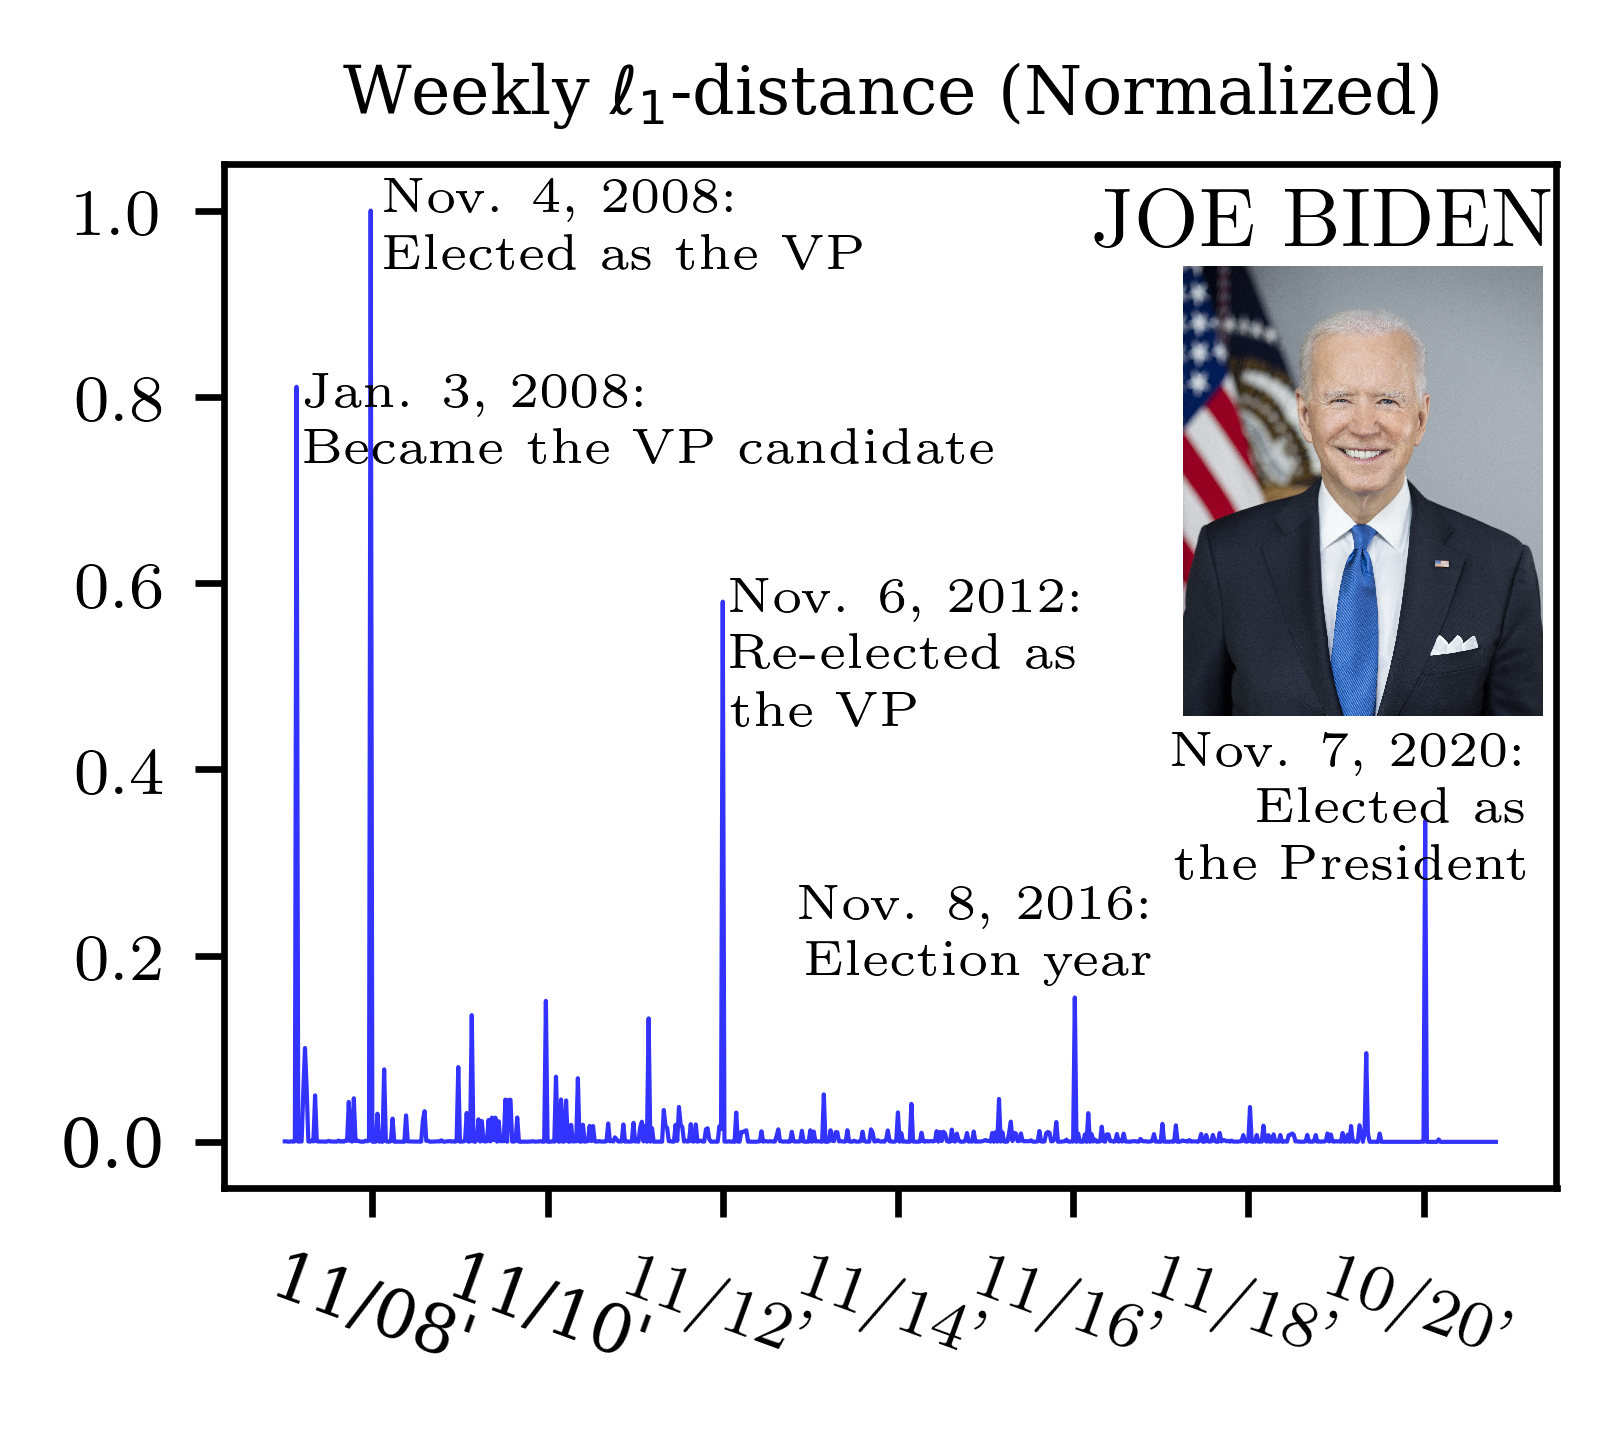

In [17]:


target_node_ids = [
    [2277320, "entity_9779081","arnold schwarzenegger"],
    [1003585, "entity_8623844","al franken"],
    [953535, "entity_2718902","joe biden"],
]

pd_target_nodes = pd.DataFrame(target_node_ids, columns = ['external_id', 'external_uuid', 'desc'])
pd_target_nodes

target_status = dict()
prev_ppv_dict = dict()

top_k = 500
for entry in pd_target_nodes.to_records():
    #print (entry[1], entry[3])
    target_status[entry[1]] = dict()
    target_status[entry[1]]['desc'] = entry[3]
    target_status[entry[1]]['history'] = []
    prev_ppv_dict[entry[1]] = None


track_files_path = '/Users/xingzhiguo/Downloads/DynAnomPy-alpha_5.00e-01-epsilon_1.00e-02-track_mode_definitive-dim-512-top_index_9999-push_threshold-0.00e+00-make_directed_graph_False-make_multi_graph_True'



for snapshot in tqdm(range(1,1190)):
    pickle_file = os_join(track_files_path, f'{snapshot:05}.pkl')
    if os.path.exists(pickle_file) is not True:
        for external_id in pd_target_nodes['external_id'].tolist():
            time = datetime.datetime(2000,1,1) + datetime.timedelta(days = snapshot*7)
            int_time = f'{time.strftime("%Y-%m-%d")}'
            target_status[external_id]['history'].append((int_time, 0, 0, 0, 0, 0, 0, 0, 0, 0))
        continue 

    with open(pickle_file, 'rb') as f:
        data_dict = pickle.load(f)
        zip_data = zip( data_dict['tracking_nodes_internal_ids'], \
                        data_dict['tracking_nodes_external_ids'], \
                        data_dict['node_degree'], data_dict['delta_node_degree'] \
                        )
        ppv_mat = data_dict['sp_ppv']
        #print (ppv_mat.shape)
                
        for internal_id, external_id, d, delta_d in zip_data: #track this person...
            curt_ppv = ppv_mat[internal_id,:]
            #num_supps = curt_ppv.count_nonzero()
            num_supps =  np.count_nonzero(np.array(curt_ppv.todense())[0]>=p_cutoff_threshold) 
            prev_ppv = prev_ppv_dict[external_id]
            
            if prev_ppv is None:
                l1_dis = 0.0
                l2_dis = 0.0
                emb_l1_dis = 0.0
                emb_l2_dis = 0.0
                kendalltau = 0.0
                kendalltau_v2 = 0.0
                prev_ppv_dict[external_id] = curt_ppv
            else:
                # get the top index 
                l1_dis = l_p_err_nnz_row(curt_ppv, prev_ppv, top_k = top_k, l=1)
                l2_dis = l_p_err_nnz_row(curt_ppv, prev_ppv, top_k = top_k, l=2)
                emb_l1_dis = 0.0
                emb_l2_dis = 0.0
                kendalltau = cal_kendalltau(curt_ppv, prev_ppv, top_k = top_k)
                kendalltau_v2 = cal_kendalltau_v2(curt_ppv, prev_ppv, top_k = top_k)
                # print ('curt:', id(curt_ppv))
                # print ('prev:', id(prev_ppv))
                prev_ppv_dict[external_id] = curt_ppv
            # 7 days
            time = datetime.datetime(2000,1,1) + datetime.timedelta(days = snapshot*7)
            int_time = f'{time.strftime("%Y-%m-%d")}'
            target_status[external_id]['history'].append((int_time, num_supps, d, delta_d, l1_dis, l2_dis, kendalltau, kendalltau_v2, emb_l1_dis, emb_l2_dis))

df_history_person = dict()
for external_id in target_status.keys():
    node_desc = target_status[external_id]['desc']
    df_history = pd.DataFrame(target_status[external_id]['history'], columns = ['snapshot', 'supports','degree', 'delta-degree', 'l1-dis','l2-dis', 'tau','tau-v2', 'emb-l1-dis','emb-l2-dis'])
    df_history_person[node_desc] = df_history

df_history_person.keys()



names = ['joe biden']
pic_url = 'https://www.whitehouse.gov/wp-content/uploads/2021/04/P20210303AS-1901.jpg'
biden_image = io.imread(pic_url)
imagebox = OffsetImage(biden_image, zoom=0.018)
ab = AnnotationBbox(imagebox, (0.99, 0.90), box_alignment = (1,1),                         
                        xycoords='axes fraction',frameon=False,
                        bboxprops = dict( edgecolor='blue'))

fig, axs = plt.subplots(len(names),1, figsize =(2.8,2.5*len(names)), dpi = 600, sharex=True)
plt.rcParams['text.usetex'] = True
axs = [axs]
def _extract_month_year(yyyymmdd):
    yyyymmdd = yyyymmdd.split('-')
    y=yyyymmdd[0]
    m = yyyymmdd[1]
    d = yyyymmdd[2]
    return f'{m}/{y[2:4]}\''


plot_start = 410
plot_num = 720
for ax_id, name in enumerate(names):
    ax =  axs[ax_id]
    if df_history_person[name].shape[0] == 0:
        continue 
    # df_history_person[name].plot(x = 'snapshot', y = 'l1-dis', marker='o', ax = ax) #l2-dis
    x = df_history_person[name]['snapshot'].to_numpy()[plot_start:plot_start+plot_num]
    y = df_history_person[name]['l1-dis'].to_numpy()[plot_start:plot_start+plot_num]
    y = y/max(y)
    ax.plot(x,y,label = 'L-1 distance', lw = 0.5, color = 'blue', marker = '', alpha = 0.8)
    ax.set_xticks(x[52::52*2])
    ax.set_xticklabels([ _extract_month_year(_) for _ in x[52::52*2]], rotation=-20, ha = 'center')
    
    ax.add_artist(ab)
    ax.text(1.0, 0.98, f'{name.upper()}', horizontalalignment='right',verticalalignment='top',transform = ax.transAxes)
    ax.set_title(r'Weekly $\ell_1$-distance (Normalized)')


    time_desc = [
        (0.06, 0.80,'left','Jan.  3, 2008:\nBecame the VP candidate'),
        (0.12, 0.99,'left','Nov. 4, 2008:\nElected as the VP'),
        (0.38, 0.60,'left','Nov. 6, 2012:\nRe-elected as\nthe VP'),
        (0.70, 0.30,'right','Nov. 8, 2016:\nElection year'),
        (0.98, 0.45,'right','Nov. 7, 2020:\nElected as \nthe President'), 
    ]

    for x, y, ha, text in time_desc:
        ax.text(x, y, text, horizontalalignment=ha,verticalalignment='top',transform = ax.transAxes, size= 6)


handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(wspace=0.0, hspace=0.05)
fig.tight_layout()


## Running time profile tracking

In [19]:
import pstats
p = pstats.Stats(os_join(local_out_dir, 'profile_dynppe-anom-node-wise-v1.cProfile')) #profile_dynppe_numba_enron_v6.cProfile profile_dynppe_numba_darpa_v3
p.sort_stats('cumtime').print_stats(100)
